In [1]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime

major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [2]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[0]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
print(data.shape)
test_size = 0.047 # m15
test_len = int(test_size * len(data))
print("test length", test_len)
# train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
# data = train_data
# data = test_data
# print(data.shape)
display(data)

EUR/USD
(10000, 13)
test length 470


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-08-03 21:15:00,1.18600,1.18602,1.18609,1.18589,1.18644,1.18644,1.18648,1.18639,39,1.186220,1.186285,1.186140,1.186230
2021-08-03 21:30:00,1.18602,1.18613,1.18613,1.18602,1.18644,1.18651,1.18651,1.18641,86,1.186230,1.186320,1.186215,1.186320
2021-08-03 21:45:00,1.18613,1.18621,1.18623,1.18607,1.18651,1.18648,1.18651,1.18635,116,1.186320,1.186370,1.186210,1.186345
2021-08-03 22:00:00,1.18621,1.18632,1.18638,1.18617,1.18648,1.18646,1.18651,1.18636,262,1.186345,1.186445,1.186265,1.186390
2021-08-03 22:15:00,1.18632,1.18647,1.18653,1.18631,1.18646,1.18661,1.18666,1.18645,632,1.186390,1.186595,1.186380,1.186540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24 17:00:00,1.13112,1.13090,1.13135,1.13073,1.13131,1.13126,1.13145,1.13101,4825,1.131215,1.131400,1.130870,1.131080
2021-12-24 17:15:00,1.13092,1.13106,1.13131,1.13074,1.13127,1.13138,1.13170,1.13097,3389,1.131095,1.131505,1.130855,1.131220
2021-12-24 17:30:00,1.13106,1.13094,1.13108,1.13085,1.13137,1.13132,1.13143,1.13114,1348,1.131215,1.131255,1.130995,1.131130


In [3]:
aroon = ta.trend.AroonIndicator(close=data['close'], window=25, fillna=False)

In [4]:
data['aroon_up'] = aroon.aroon_up()
data['aroon_down'] = aroon.aroon_down()
data['aroon_ind'] = aroon.aroon_indicator()
data.dropna(inplace=True)

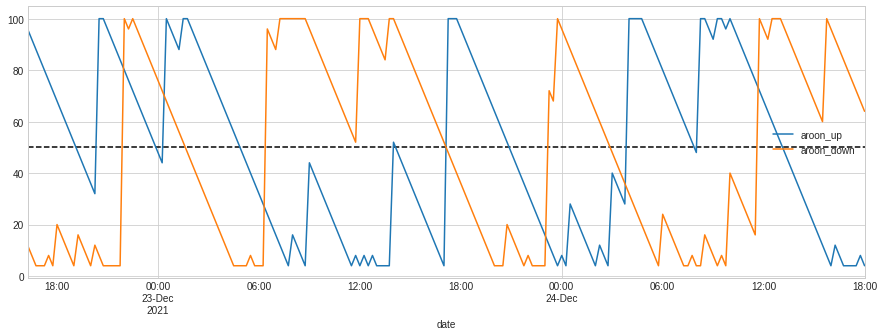

In [5]:
ax = data[['aroon_up', 'aroon_down']].iloc[-200:].plot(figsize=(15,5))
plt.hlines(y=50, xmin=data.iloc[-200:].index[0], xmax=data.iloc[-200:].index[-1], colors='k', linestyles="--")
plt.show()

In [6]:
if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

In [7]:
# aroon up > aroon down --> long
# aroon up < aroon down --> short

data['aroon_signal'] = np.where(data['aroon_up'] > data['aroon_down'], 1, 
                       np.where(data['aroon_up'] < data['aroon_down'], -1, 0))

In [8]:
print(data['aroon_signal'].value_counts())
print("-"*50)
print(data['aroon_signal'].diff(1).apply(np.abs).value_counts())

 1    272
-1    198
Name: aroon_signal, dtype: int64
--------------------------------------------------
0.0    453
2.0     16
Name: aroon_signal, dtype: int64


  0%|          | 0/469 [00:00<?, ?it/s]

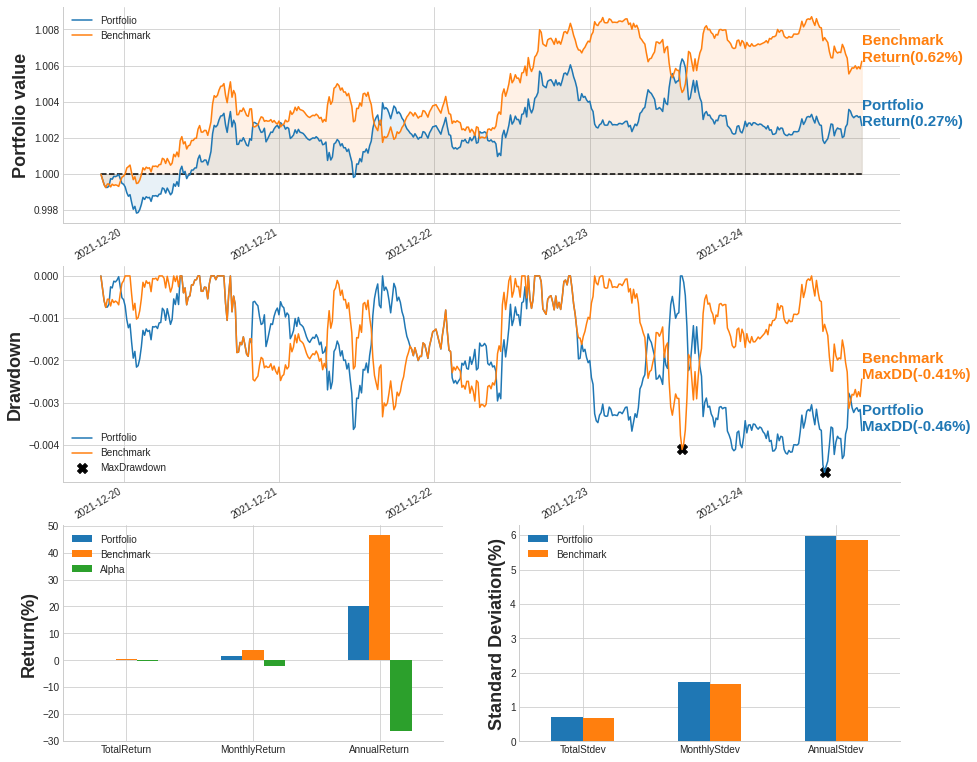

----------------------------------------------------------------------
Data length: |4 days 21:30:00|
Data range from |2021-12-19 20:30:00| to |2021-12-24 18:00:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │       0.269 │       0.624 │  -0.355 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │       1.646 │       3.822 │  -2.176 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      20.024 │      46.501 │ -26.477 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │    

In [9]:
backtest = IterativeBacktester(data, data['aroon_signal'], freq)
backtest.backtest()
backtest.results()